In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leash-BELKA/sample_submission.csv
/kaggle/input/leash-BELKA/train.parquet
/kaggle/input/leash-BELKA/test.parquet
/kaggle/input/leash-BELKA/train.csv
/kaggle/input/leash-BELKA/test.csv


In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 47.1 MB/s eta 0:00:00:00:0100:01


In [3]:
!pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 64.7 MB/s eta 0:00:00:00:0100:01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}
Best cross-validation score for MLP: 0.7999999999999999
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__solver=adam; total time=   4.5s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__solver=adam; total time=   4.5s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__solver=adam; total time=   4.5s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=adaptive, mlp__solver=sgd; total time=  22.4s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_s

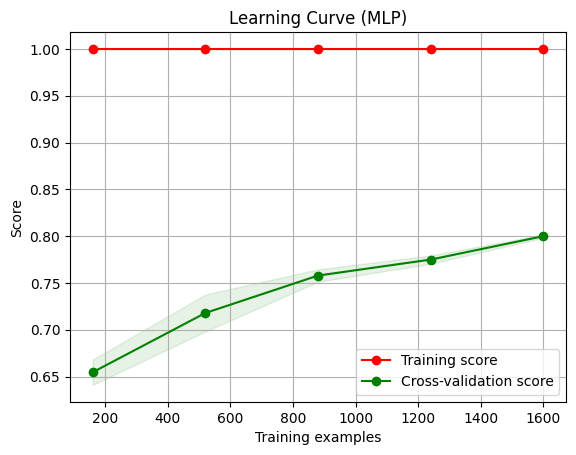

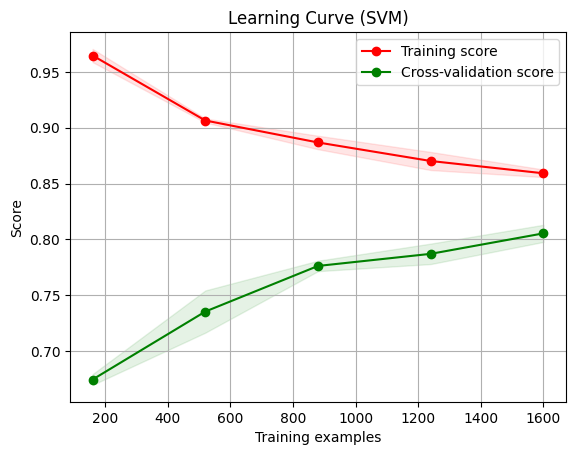

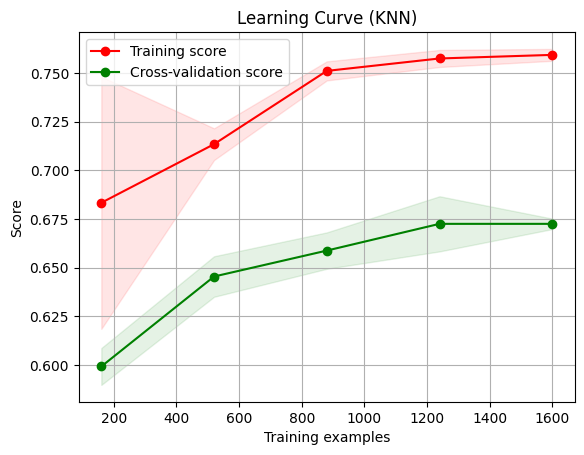

[CV] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=uniform; total time=   4.1s
[CV] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance; total time=   3.9s
[CV] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform; total time=   4.0s
[CV] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=uniform; total time=   1.3s
[CV] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance; total time=   1.5s
[CV] END knn__metric=minkowski, knn__n_neighbors=5, knn__weights=uniform; total time=   1.2s
[CV] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform; total time=   1.3s
[CV] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance; total time=   1.0s
[CV] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=uniform; total time=   1.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__solver=sgd; total time=  20.3s
[CV] END mlp__

In [4]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import duckdb

# Function to generate ECFPs
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return [0] * bits
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

# Load and preprocess data
train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.parquet'

con = duckdb.connect()
query = f"""
    (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 0 ORDER BY random() LIMIT 1500)  -- Reduced to 1500
    UNION ALL
    (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 1 ORDER BY random() LIMIT 1500)  -- Reduced to 1500
"""
df = con.query(query).df()
con.close()

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)
df['ecfp'] = df['molecule'].apply(generate_ecfp)

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + list(protein) for ecfp, protein in zip(df['ecfp'], protein_onehot)]
y = df['binds'].values

# Split the data into train and test sets with a fixed random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Neural Network
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000))  # Increased max_iter to 1000
])

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate': ['constant', 'adaptive'],
}

mlp_grid_search = GridSearchCV(mlp_pipeline, param_grid=mlp_param_grid, cv=3, n_jobs=-1, verbose=2)  # Reduced cv to 3
mlp_grid_search.fit(X_train, y_train)

print("Best parameters for MLP:", mlp_grid_search.best_params_)
print("Best cross-validation score for MLP:", mlp_grid_search.best_score_)
mlp_best = mlp_grid_search.best_estimator_

# Plot learning curve for the best MLP model
plot_learning_curve(mlp_best, "Learning Curve (MLP)", X_train, y_train, cv=3, n_jobs=-1)  # Reduced cv to 3

# Support Vector Machine
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

svm_param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__gamma': ['scale', 'auto'],
}

svm_grid_search = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, cv=3, n_jobs=-1, verbose=2)  # Reduced cv to 3
svm_grid_search.fit(X_train, y_train)

print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best cross-validation score for SVM:", svm_grid_search.best_score_)
svm_best = svm_grid_search.best_estimator_

# Plot learning curve for the best SVM model
plot_learning_curve(svm_best, "Learning Curve (SVM)", X_train, y_train, cv=3, n_jobs=-1)  # Reduced cv to 3

# K-Nearest Neighbors
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn_grid_search = GridSearchCV(knn_pipeline, param_grid=knn_param_grid, cv=3, n_jobs=-1, verbose=2)  # Reduced cv to 3
knn_grid_search.fit(X_train, y_train)

print("Best parameters for KNN:", knn_grid_search.best_params_)
print("Best cross-validation score for KNN:", knn_grid_search.best_score_)
knn_best = knn_grid_search.best_estimator_

# Plot learning curve for the best KNN model
plot_learning_curve(knn_best, "Learning Curve (KNN)", X_train, y_train, cv=3, n_jobs=-1)  # Reduced cv to 3

# Evaluation Metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Average Precision Score:", average_precision_score(y_test, y_pred_proba))

print("\nEvaluation for MLP:")
evaluate_model(mlp_best, X_test, y_test)

print("\nEvaluation for SVM:")
evaluate_model(svm_best, X_test, y_test)

print("\nEvaluation for KNN:")
evaluate_model(knn_best, X_test, y_test)

plt.show()
